In [276]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Data Preparation

In [2]:
data = pd.read_csv('Maternal Health Risk Data Set.csv')
data.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [3]:
X = data.drop('RiskLevel', axis=1)
y = data['RiskLevel']
X, y

(      Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate
 0      25         130           80  15.0      98.0         86
 1      35         140           90  13.0      98.0         70
 2      29          90           70   8.0     100.0         80
 3      30         140           85   7.0      98.0         70
 4      35         120           60   6.1      98.0         76
 ...   ...         ...          ...   ...       ...        ...
 1009   22         120           60  15.0      98.0         80
 1010   55         120           90  18.0      98.0         60
 1011   35          85           60  19.0      98.0         86
 1012   43         120           90  18.0      98.0         70
 1013   32         120           65   6.0     101.0         76
 
 [1014 rows x 6 columns],
 0       high risk
 1       high risk
 2       high risk
 3       high risk
 4        low risk
           ...    
 1009    high risk
 1010    high risk
 1011    high risk
 1012    high risk
 1013     mid risk
 Name: 

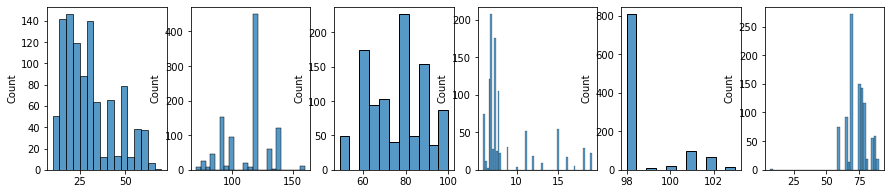

In [16]:
plt.figure(figsize=(15, 3))
for i in range(X.shape[1]):
    ax = plt.subplot(1, X.shape[1], i+1)
    sns.histplot(X.values[:, i], ax=ax)

## Scaling X

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

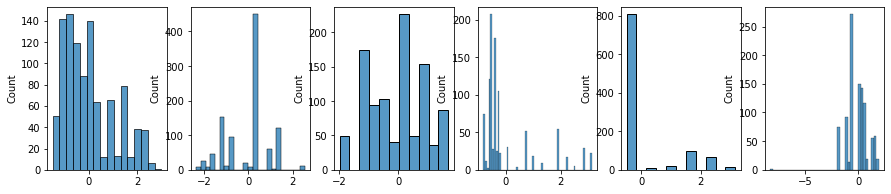

In [19]:
plt.figure(figsize=(15, 3))
for i in range(X.shape[1]):
    ax = plt.subplot(1, X.shape[1], i+1)
    sns.histplot(X_scaled[:, i], ax=ax)

## Encoding Y

In [20]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

## Class distribution

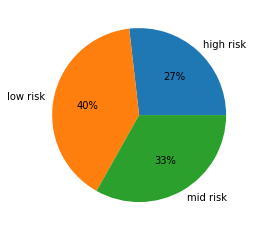

In [22]:
y_unique, y_counts = np.unique(y_encoded, return_counts=True)
y_unique = encoder.inverse_transform(y_unique)
plt.pie(y_counts, labels=y_unique, autopct='%.0f%%')
plt.show()

## Splitting the data

In [249]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, shuffle=True, test_size=0.3)
print(X_train.shape, X_test.shape)

(709, 6) (305, 6)


In [263]:
# Base function for cross validation and grid search hyperparameter tunning
def do_gridsearch_cv(parameters, base_estimator, model_name):
    clf = GridSearchCV(base_estimator, parameters, cv=10, return_train_score=True)
    clf.fit(X_train, y_train)
    print('---'+model_name+'---')
    print('Best parameters:')
    print(clf.best_params_)
    print('Best Test Score:')
    print(clf.best_score_)
    print('Best Train Score:')
    print(max(clf.cv_results_['mean_train_score']))
    return clf.best_estimator_, pd.DataFrame(clf.cv_results_)

In [259]:
# function for visualizing gridsearch and cross validation results
def visualize_cv_hyperparameter_tuning(results, model_name):
    param_columns = [column for column in results.columns if 'param_' in column]
    configs = results[param_columns].astype('str').agg('-'.join, axis=1)
    fig = plt.figure(figsize=(20, 20))
    ax = plt.subplot(2, 1, 1)
    ax.set_title('GridSearch Results for '+model_name+' (Test)')
    plt.errorbar(configs.values, results['mean_test_score'], yerr=results['std_test_score'],
                 label='Cross Validation KFolds Test Score', capsize=10, ecolor='black')
    plt.scatter(configs.values, results['mean_test_score'], color='orange', zorder=3)
    plt.legend()
    plt.xticks(rotation=90)
    plt.xlabel('Parameters:'+'-'.join([column.replace('param_', '') for column in param_columns]))
    plt.axhline(results['mean_test_score'].max(), linestyle='--')
    plt.axvline(configs.iloc[results['mean_test_score'].argmax()], linestyle='--')
    
    ax = plt.subplot(2, 1, 2)
    ax.set_title('GridSearch Results for '+model_name+' (Train)')
    plt.errorbar(configs.values, results['mean_train_score'], yerr=results['std_train_score'],
                 label='Cross Validation KFolds Train Score', capsize=10, ecolor='black')
    plt.scatter(configs.values, results['mean_train_score'], color='orange', zorder=3)
    plt.legend()
    plt.xticks(rotation=90)
    plt.xlabel('Parameters:'+'-'.join([column.replace('param_', '') for column in param_columns]))
    plt.tight_layout()
    plt.show()

In [302]:
# testing a model on the test-set
# confusion matrix
def eval_model(model, model_name):
    print("Evaluating test set on", model_name)
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    matrix = confusion_matrix(y_test, y_pred)
    labels = encoder.inverse_transform(list(range(len(matrix))))
    matdf = pd.DataFrame(matrix, index=labels, columns=labels)
    return matdf

# DecisionTree

In [266]:
parameters = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}
dectree = DecisionTreeClassifier()
best_dectree, results = do_gridsearch_cv(parameters, dectree, 'DecesionTree')

---DecesionTree---
Best parameters:
{'class_weight': None, 'criterion': 'entropy', 'max_features': 'sqrt', 'splitter': 'best'}
Best Test Score:
0.8250704225352112
Best Train Score:
0.9301045913236298


This plot shows both Mean-Accuracy vs Parameter-Set, and the Std of accuracy across the 10 folds

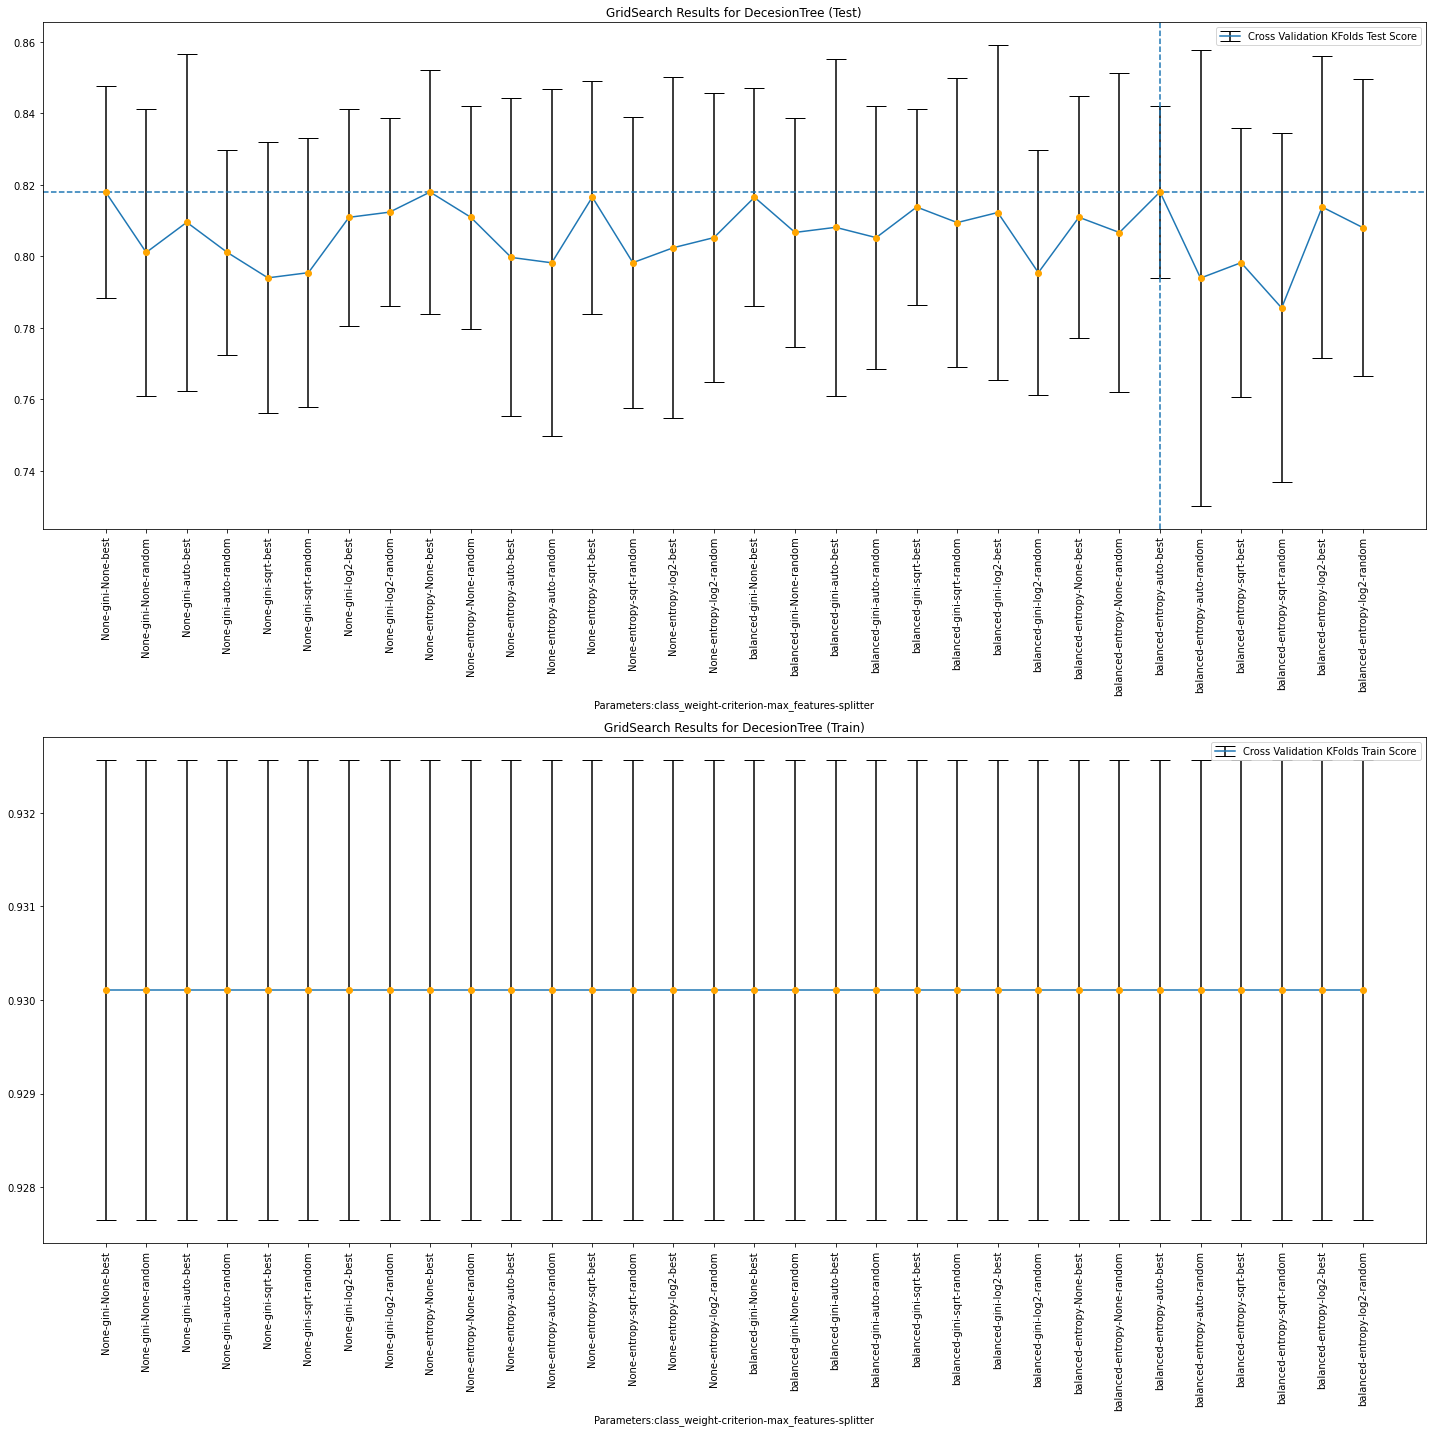

In [260]:
visualize_cv_hyperparameter_tuning(results, 'DecesionTree')

### Note
<p>Very high variance in cross validation test scores, this could be due to imperfect-generalization or overfitting.</p>

## DecisionTree Test

In [284]:
eval_model(best_dectree, 'DecisionTree')

Evaluating test set on DecisionTree
Accuracy: 0.8524590163934426


,high risk,low risk,mid risk
high risk,72,1,5
low risk,4,107,21
mid risk,3,11,81


# KNN

In [286]:
parameters = {
    'n_neighbors': list(range(1, 10)),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}
knn = KNeighborsClassifier()
best_knn, results = do_gridsearch_cv(parameters, knn, 'KNN')

---KNN---
Best parameters:
{'algorithm': 'ball_tree', 'n_neighbors': 8, 'weights': 'distance'}
Best Test Score:
0.8165593561368208
Best Train Score:
0.9410749064221624


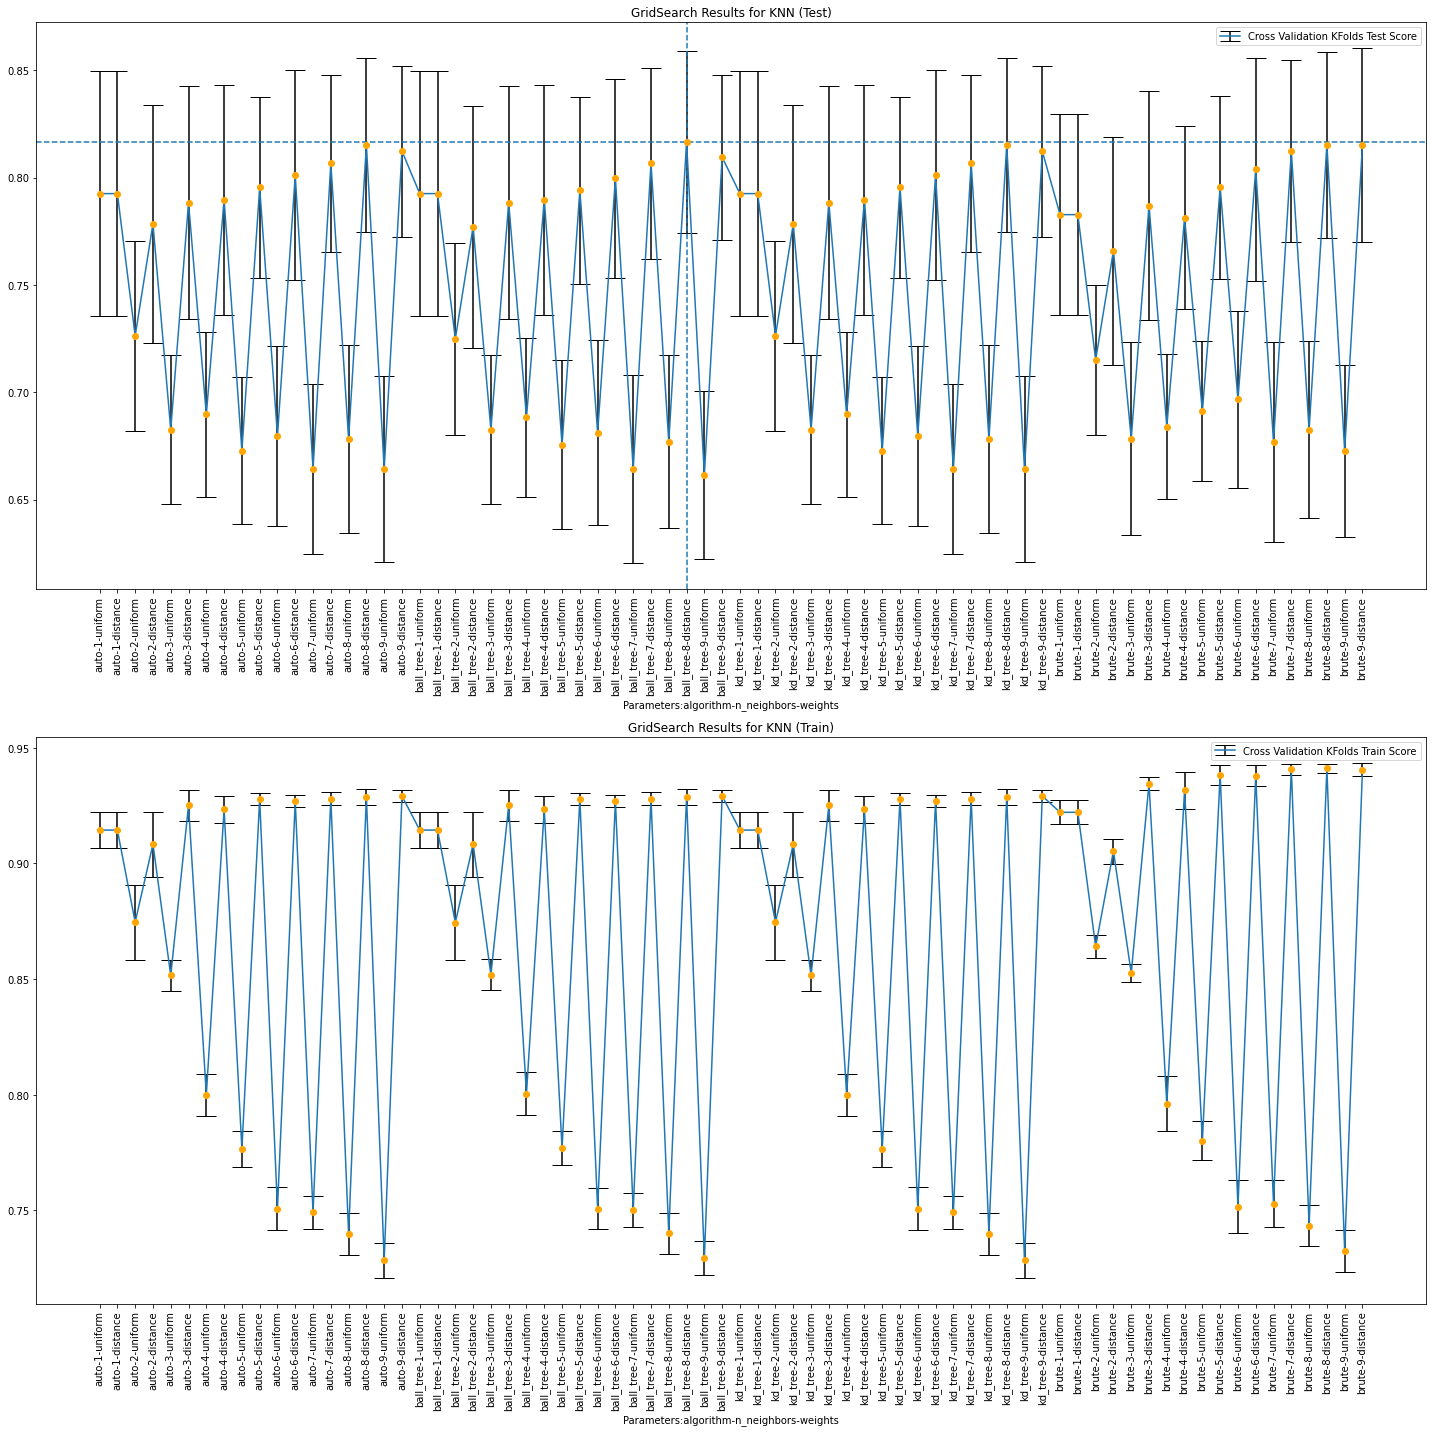

In [287]:
visualize_cv_hyperparameter_tuning(results, 'KNN')

## KNN Test

In [290]:
eval_model(best_knn, 'KNN')

Evaluating test set on KNN
Accuracy: 0.7868852459016393


,high risk,low risk,mid risk
high risk,57,6,15
low risk,4,100,28
mid risk,3,9,83


# SVM

In [292]:
parameters = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['auto', 'scale'],
    'class_weight': [None, 'balanced']
}
svm = SVC()
best_svm, results = do_gridsearch_cv(parameters, svm, 'SVM')

---SVM---
Best parameters:
{'class_weight': None, 'gamma': 'auto', 'kernel': 'rbf'}
Best Test Score:
0.6867806841046276
Best Train Score:
0.7063139898254032


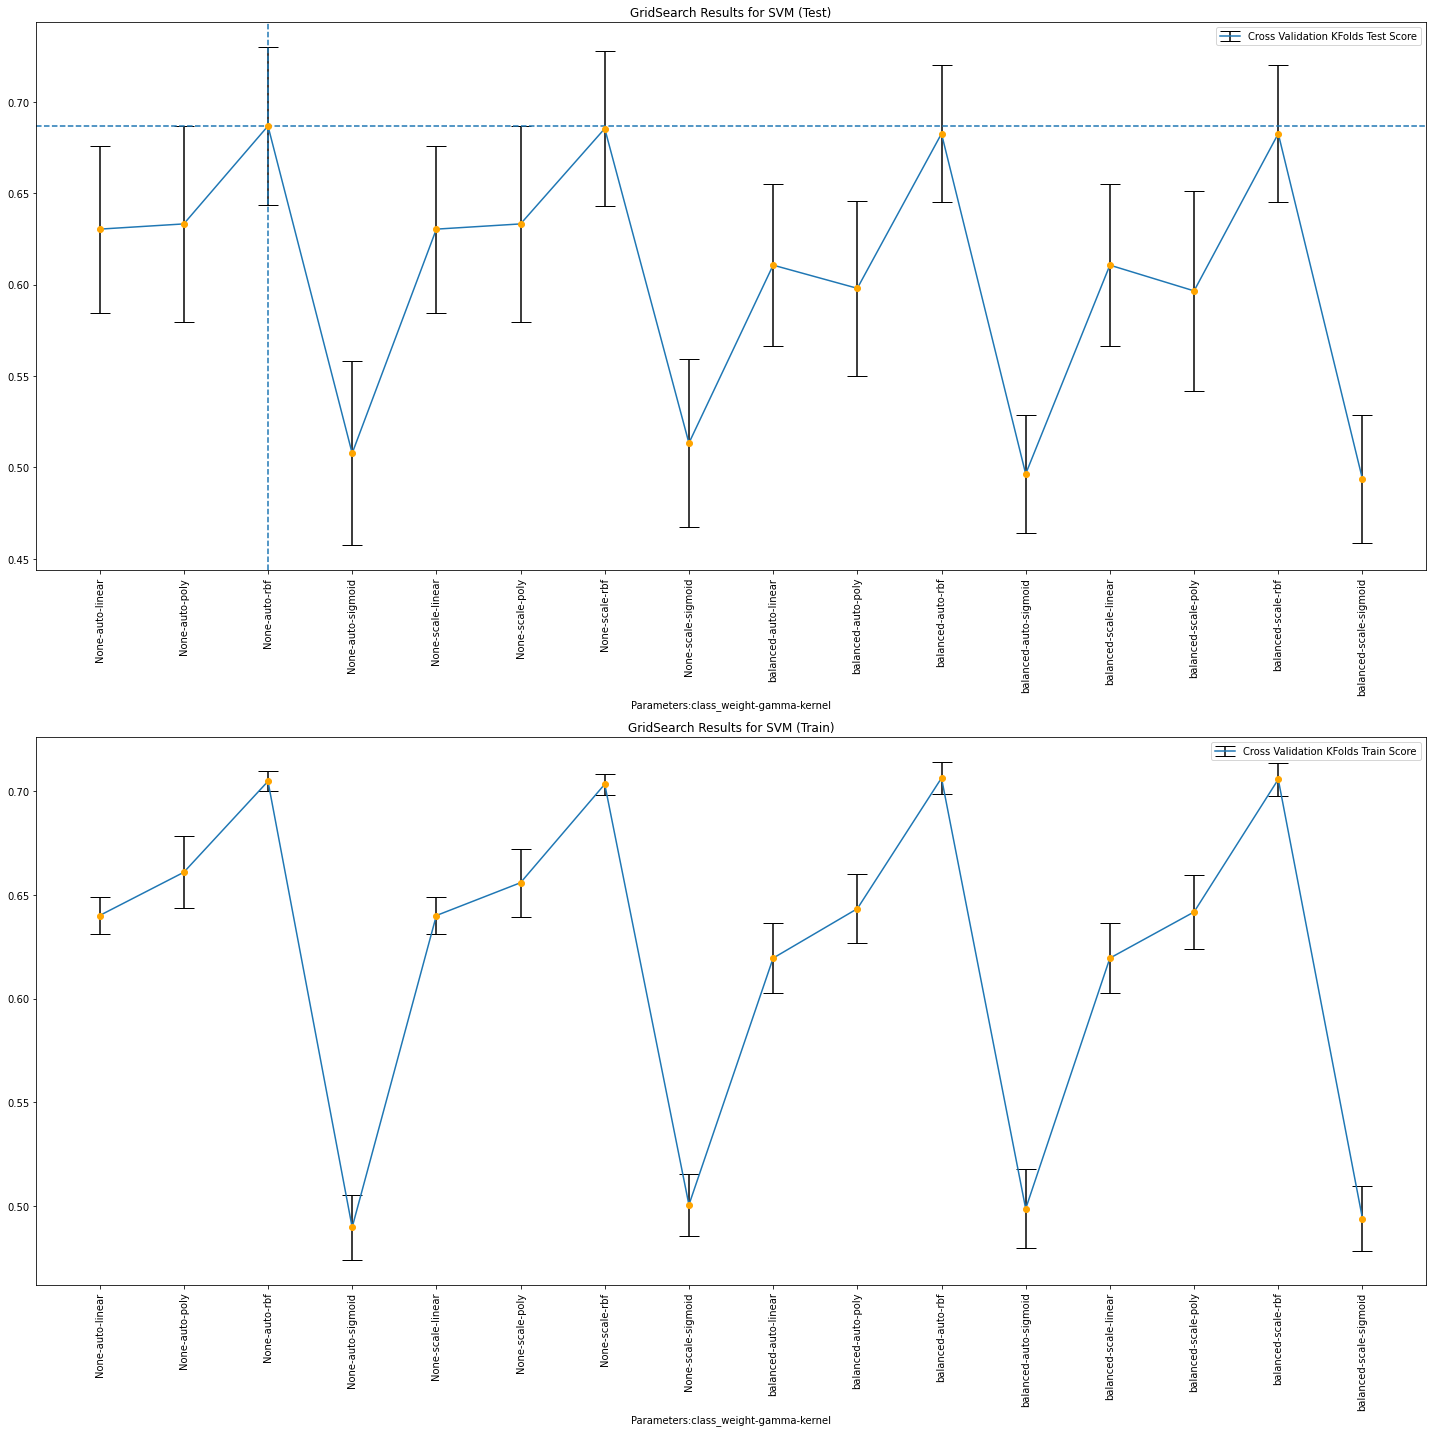

In [293]:
visualize_cv_hyperparameter_tuning(results, 'SVM')

# SVM Test

In [294]:
eval_model(best_svm, 'SVM')

Evaluating test set on SVM
Accuracy: 0.7213114754098361


,high risk,low risk,mid risk
high risk,62,7,9
low risk,6,116,10
mid risk,9,44,42


# RandomForest

In [301]:
parameters = {
    'bootstrap': [True],
    'max_depth': [None, 20, 50, 100],
    'max_features': [2, 3],
    'n_estimators': [50, 100]
}
forest = RandomForestClassifier()
best_forest, results = do_gridsearch_cv(parameters, forest, 'RandomForest')

---RandomForest---
Best parameters:
{'bootstrap': True, 'max_depth': 50, 'max_features': 2, 'n_estimators': 50}
Best Test Score:
0.8306841046277667
Best Train Score:
0.9301045913236298


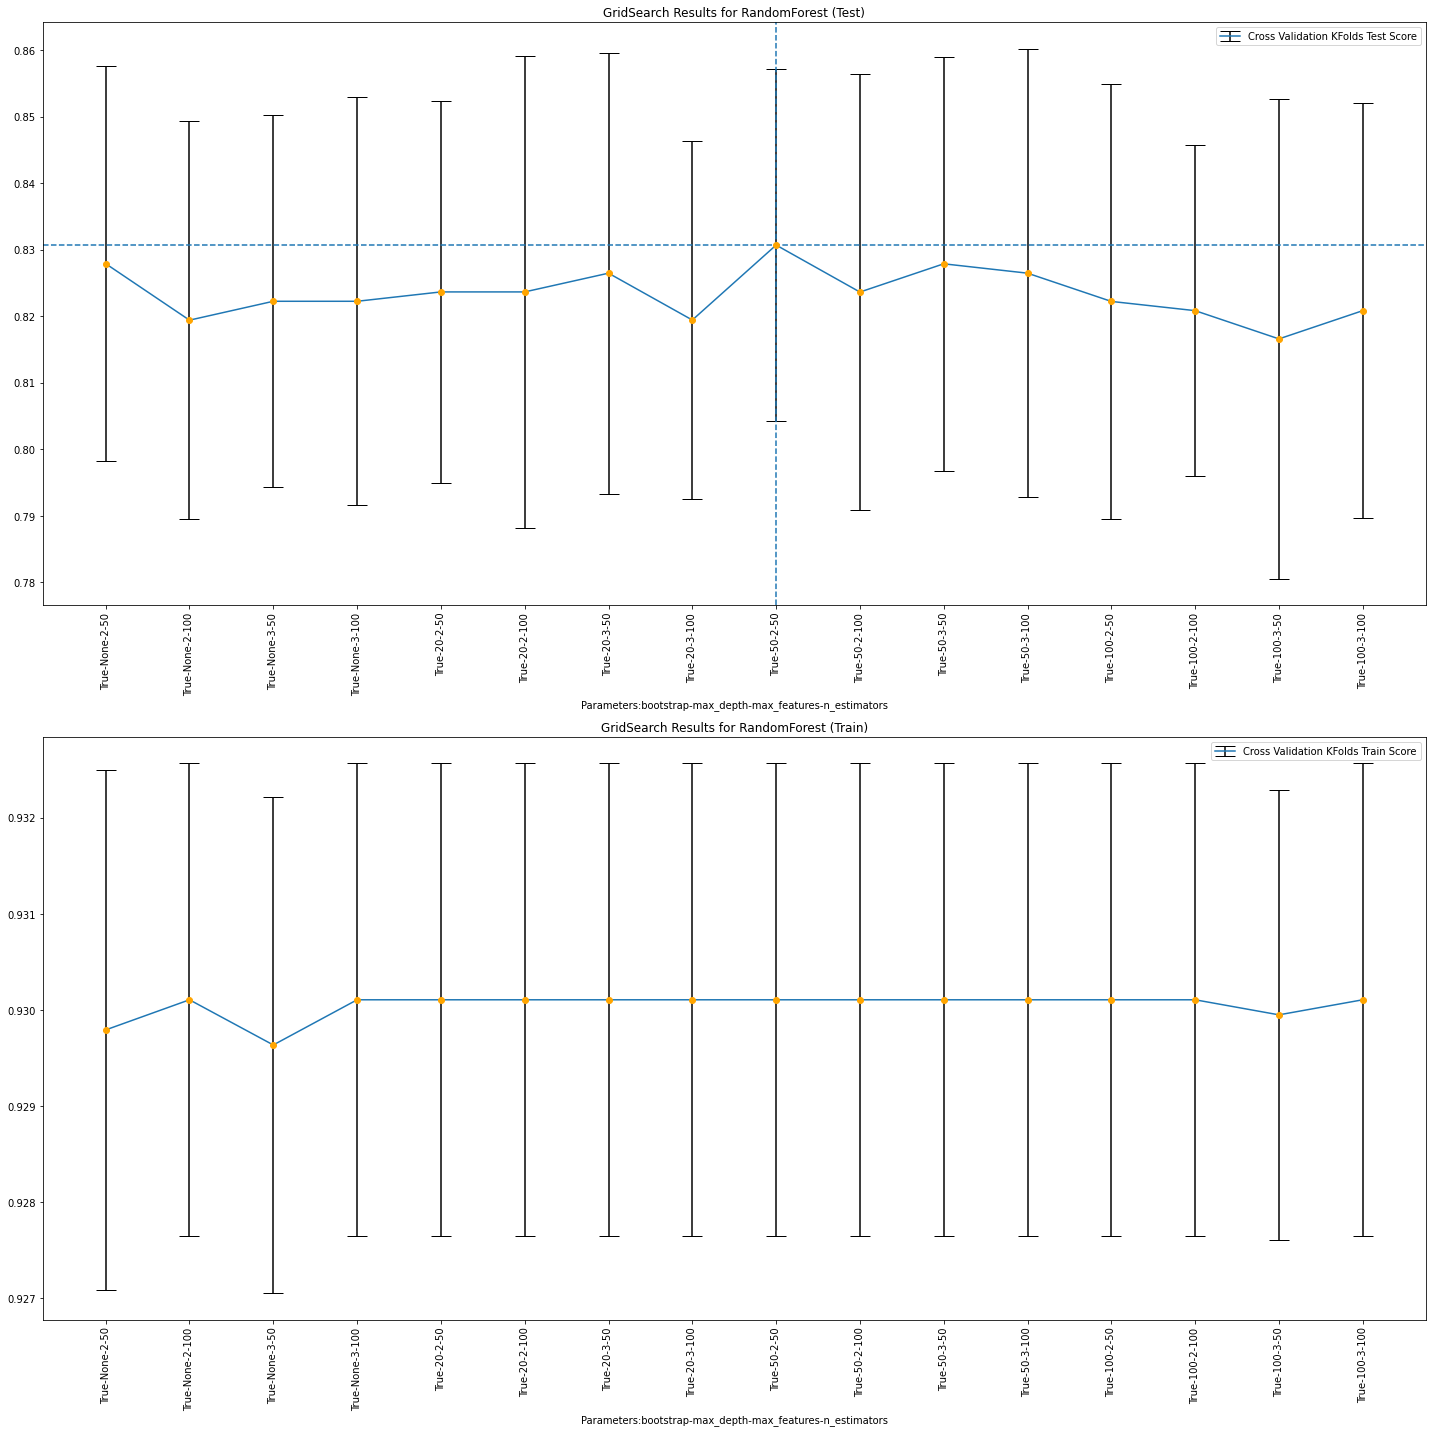

In [303]:
visualize_cv_hyperparameter_tuning(results, 'RandomForest')

## RandomForest Test

In [300]:
eval_model(best_forest, 'RandomForest')

Evaluating test set on RandomForest
Accuracy: 0.8426229508196721


,high risk,low risk,mid risk
high risk,69,2,7
low risk,3,106,23
mid risk,3,10,82


# Analysis

<table>
    <thead>
        <tr>
            <th>Model</th>
            <th>Train Accuracy</th>
            <th>Cross Validation Accuracy</th>
            <th>Test Accuracy</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <th>DecisionTree</th>
            <td>0.93</td>
            <td>0.82</td>
            <td>0.85</td>
        </tr>
        <tr>
            <th>KNN</th>
            <td>0.94</td>
            <td>0.81</td>
            <td>0.78</td>
        </tr>
        <tr>
            <th>SVM</th>
            <td>0.70</td>
            <td>0.68</td>
            <td>0.72</td>
        </tr>
        <tr>
            <th>RandomForest</th>
            <td>0.87</td>
            <td>0.77</td>
            <td>0.80</td>
        </tr>
    </tbody>
</table>

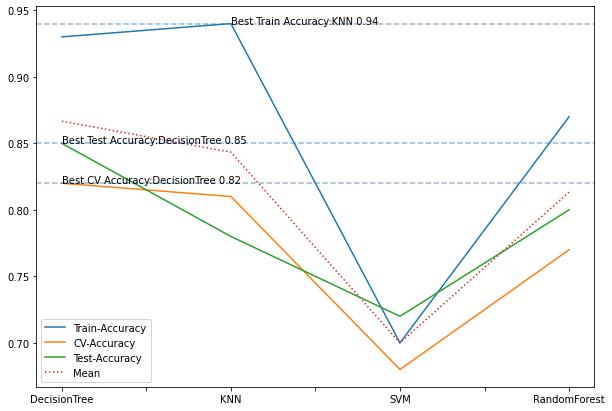

In [329]:
overall = pd.DataFrame({
    'Train-Accuracy': [0.93, 0.94, 0.70, 0.87],
    'CV-Accuracy': [0.82, 0.81, 0.68, 0.77],
    'Test-Accuracy': [0.85, 0.78, 0.72, 0.80]
}, index=['DecisionTree', 'KNN', 'SVM', 'RandomForest'])
overall['Mean'] = overall.mean(axis=1)

plt.figure(figsize=(10, 7))
ax = overall.drop('Mean', axis=1).plot(ax=plt.gca())
ax.plot(overall['Mean'], label='Mean', linestyle=':')
best_train = overall['Train-Accuracy'].argmax()
best_cv = overall['CV-Accuracy'].argmax()
best_test = overall['Test-Accuracy'].argmax()
best_mean = overall['Mean'].argmax()
ax.axhline(overall['Train-Accuracy'].max(), linestyle='--', alpha=0.5)
ax.text(overall.index[best_train], overall['Train-Accuracy'].max(),
        'Best Train Accuracy:'+overall.index[best_train]+" {0}".format(overall['Train-Accuracy'].max()))
ax.axhline(overall['CV-Accuracy'].max(), linestyle='--', alpha=0.5)
ax.text(overall.index[best_cv], overall['CV-Accuracy'].max(),
        'Best CV Accuracy:'+overall.index[best_cv]+" {0}".format(overall['CV-Accuracy'].max()))
ax.axhline(overall['Test-Accuracy'].max(), linestyle='--', alpha=0.5)
ax.text(overall.index[best_test], overall['Test-Accuracy'].max(),
        'Best Test Accuracy:'+overall.index[best_test]+" {0}".format(overall['Test-Accuracy'].max()))
plt.legend()